In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.special import gamma, polygamma

import sympy
from sympy.stats import Beta, density, E, variance
from sympy import Symbol, simplify, pprint, expand_func, S, pi, Matrix, Array, symbols, IndexedBase, Idx, lambdify
from sympy import Sum, Integral, IndexedBase, Function
from sympy.stats import Expectation

import scipy.optimize

from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count() - 2

import tensorflow as tf

In [ ]:
# beta bernoulli distribution 
import sympy.functions.special.beta_functions as beta_func
beta_func.beta()

# Generate data

In [2]:
ks = tf.keras
mnist = ks.datasets.mnist

(x_train, h_train),(x_test, h_test) = mnist.load_data()

In [128]:
noise = 5
eps = .001

x_train, x_test = x_train / 255.0, x_test / 255.0

u_train = np.random.randint(0,10,h_train.shape)
y_train = np.clip(h_train + u_train + np.random.normal(0,noise,h_train.shape), 0,18)//3

u_train = np.clip(u_train/9, eps, 1-eps)
y_train = np.clip(y_train/6, eps, 1-eps)

u_test = np.random.randint(0,10,h_test.shape)
y_test = np.clip(h_test + u_test + np.random.normal(0,noise,h_test.shape), 0,18)//3
y_test = np.clip(y_test/6, eps, 1-eps)

N = len(y_train)

## Torch

In [37]:
from torch import relu
import torch
from torch.nn.parameter import Parameter
import torch.distributions.beta

In [269]:
dtype = torch.float
device = torch.device("cuda:0") # Uncomment this to run on GPU

N, D_in, K = 60000, 2, 100

y = torch.randn(N, D_in, device=device, dtype=dtype)

a = torch.tensor(np.linspace(.1,6,K), device=device, dtype=dtype, requires_grad=True)
b = torch.tensor(np.linspace(6,.1,K), device=device, dtype=dtype, requires_grad=True)
pz = torch.tensor(np.ones(K)/K, device=device, dtype=dtype, requires_grad=True)

In [270]:
def cutoff_loss(x, a, b):
    eps = .0001
    x = x.cuda()
    a = torch.tensor([a], dtype=torch.double).cuda()
    b = torch.tensor([b], dtype=torch.double).cuda()
    return (relu(x-b)/torch.abs(b+eps) + relu(a-x)/torch.abs(a+eps))

In [ ]:
class MixModel(torch.nn.Module):
    def __init__(self, K):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MixModel, self).__init__()
        self.a_u = Parameter(torch.tensor(torch.rand(1,K)*50, dtype=torch.double, requires_grad=True))
        self.b_u = Parameter(torch.tensor(torch.rand(1,K)*50, dtype=torch.double, requires_grad=True))
        self.a_y = Parameter(torch.tensor(torch.rand(1,K)*50, dtype=torch.double, requires_grad=True))
        self.b_y = Parameter(torch.tensor(torch.rand(1,K)*50, dtype=torch.double, requires_grad=True))
        self.p_z = Parameter(torch.tensor(torch.ones(1,K)/K, dtype=torch.double, requires_grad=True))

    def forward(self, yu):
        """
        yu must be 2*N
        """
        U = torch.distributions.beta.Beta(torch.tensor(self.a_u), torch.tensor(self.b_u))
        Y = torch.distributions.beta.Beta(torch.tensor(self.a_y), torch.tensor(self.b_y))
        f_YU = torch.exp(Y.log_prob(yu[:,:1]) + U.log_prob(yu[:,-1:]))
        neg_log_ll = -torch.log((self.p_z*f_YU).sum(1)).mean()
        w_constraints = cutoff_loss(self.p_z,0,1).sum()*10000 + cutoff_loss(
                        torch.cat([self.a_u, self.a_y, self.b_u, self.b_y]),0.1,50).sum()*100
        return neg_log_ll + w_constraints

y = torch.tensor(y_train, dtype=torch.double).cuda()
u = torch.tensor(u_train, dtype=torch.double).cuda()
model = MixModel(K).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
yu = torch.stack([y,u], 1)
for t in range(5001):
    loss = model(yu)
    if t % 100 == 0:
        print("%d: %.1f" % (t,loss.item()))
    """print(model.a_u.data)
    print(model.a_y.data)
    print(model.b_u.data)
    print(model.b_y.data)
    print(model.p_z.data)"""

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: 1.9
100: -0.3
200: -0.9
300: -1.3
400: -1.7
500: -2.0
600: -2.3
700: -2.5
800: -2.8
900: -3.0
1000: -3.2
1100: -3.4
1200: -3.5
1300: -3.7
1400: -3.8
1500: -4.0
1600: -4.1
1700: -4.2
1800: -4.3


## Dirichlet distribution

In [5]:
K = 15

In [6]:
a_y = IndexedBase("a_y", K, positive=True)
b_y = IndexedBase("b_y", K, positive=True)
a_u = IndexedBase("a_u", K, positive=True)
b_u = IndexedBase("b_u", K, positive=True)
P_z = IndexedBase("P_z", K, positive=True)
y = Symbol("y", positive=True)
u = Symbol("u", positive=True)
i = Idx("i", K)
k_sym = Idx("k", K)

f_YU = density(sympy.stats.Beta('fY', a_y[i], b_y[i]))(y) * density(sympy.stats.Beta('fU', a_u[i], b_u[i]))(u)
f_YU_k = density(sympy.stats.Beta('fY_k', a_y[k_sym], b_y[k_sym]))(y) * density(sympy.stats.Beta('fU_k', a_u[k_sym], b_u[k_sym]))(u)

dP_da_k = P_z[k_sym]*f_YU_k.diff(a_y[k_sym])/Sum(P_z[i]*f_YU, (i,0,K-1))
dP_da_k_py = lambdify((a_y, b_y, a_u, b_u, P_z, y, k_sym), dP_da_k)

dP_db_k = P_z[k_sym]*f_YU_k.diff(b_y[k_sym])/Sum(P_z[i]*f_YU, (i,0,K-1))
dP_db_k_py = lambdify((a_y, b_y, a_u, b_u, P_z, y, k_sym), dP_db_k)

dP_dpz_k = f_YU_k/Sum(P_z[i]*f_YU, (i,0,K-1))
dP_dpz_k_py = lambdify((a_y, b_y, a_u, b_u, P_z, y, k_sym), dP_dpz_k)

log_ll = sympy.log(Sum(P_z[i]*f_YU, (i,0,K-1)))
log_ll_py = lambdify((a_y, b_y, a_u, b_u, P_z, y), log_ll)

dll_da_k = lambdify((a_y, b_y, a_u, b_u, P_z, y, k_sym), log_ll.diff(a_y[k_sym]), modules='sympy')
dll_db_k = lambdify((a_y, b_y, a_u, b_u, P_z, y, k_sym), log_ll.diff(b_y[k_sym]), modules='sympy')
dll_dpz_k = lambdify((a_y, b_y, a_u, b_u, P_z, y, k_sym), log_ll.diff(P_z[k_sym]), modules='sympy')

def processInput(k):
    return dll_da_k(alphas, betas, p_z, y_train, k), dll_db_k(alphas, betas, p_z, y_train, k), dll_dpz_k(alphas, betas, p_z, y_train, k)

## Gradient descent

In [376]:
loss_a = lambda a_y, b_y, a_u, b_u, p_z: -np.mean(log_ll_py(a_y, b_y, a_u, b_u, p_z, y_train))
loss_b = lambda betas, alphas, p_z: -np.mean(log_ll_py(alphas, betas, p_z, y_train))
loss_pz = lambda p_z, alphas, betas: -np.mean(log_ll_py(alphas, betas, p_z, y_train))

In [397]:
#initialization
alphas = np.random.uniform(0,50,K)#np.linspace(.1,6,K)
betas = np.random.uniform(0,50,K)#np.linspace(6,.1,K)
p_z = np.ones(K)/K #mixing coefficients

iters = 200
scale = .1
patience = 5
tol = .01
ll_hist = [-10000]*patience

a_est = np.zeros(K)
b_est = np.zeros(K)
p_z_est = np.zeros(K)

print("Mean Log Likelihood:")
for _ in range(iters):
    lll = np.mean(log_ll_py(alphas, betas, p_z, y_train))
    print("%.2f" % lll, end=", ")
    if np.max(lll - ll_hist[-patience:]) < tol:
        break
    
    alphas -= scale * scipy.optimize.approx_fprime(alphas, loss_a, 0.01, betas, p_z)
    betas -= scale * scipy.optimize.approx_fprime(betas, loss_b, 0.01, alphas, p_z)
    p_z -= scale/10 * scipy.optimize.approx_fprime(p_z, loss_pz, 0.01, alphas, betas)
    p_z = np.clip(p_z/sum(p_z), 0,1)
    ll_hist = ll_hist + [lll]
    
ll_hist = ll_hist[patience:]

Mean Log Likelihood:
-3.99, -3.85, -3.73, -3.62, -3.53, -3.44, -3.35, -3.26, -3.18, -3.10, -3.02, -2.94, -2.86, -2.79, -2.71, -2.64, -2.56, -2.49, -2.42, -2.34, -2.27, -2.20, -2.13, -2.06, -1.99, -1.92, -1.86, -1.79, -1.72, -1.66, -1.59, -1.53, -1.46, -1.40, -1.34, -1.27, -1.21, -1.15, -1.09, -1.03, -0.97, -0.92, -0.86, -0.80, -0.75, -0.69, -0.64, -0.58, -0.53, -0.48, 

## EM

In [ ]:
def processInput(k, bounds = (.05,50)):
    dP_dpz_k_sum = lambda pz: np.sum(dP_dpz_k_py(alphas, betas, p_z[:k] + [pz] + p_z[k:], y_train, k)) - N
    dP_da_k_sum = lambda a: np.sum(dP_da_k_py(alphas[:k] + [a] + alphas[k:], betas, p_z, y_train, k))
    dP_db_k_sum = lambda b: np.sum(dP_db_k_py(alphas, betas[:k] + [b] + betas[k:], p_z, y_train, k))
    dP_dpz_k_sq = lambda pz: dP_dpz_k_sum(pz)**2
    dP_da_k_sq = lambda a: dP_da_k_sum(a)**2
    dP_db_k_sq = lambda b: dP_db_k_sum(b)**2

    try:                         
        a_est = scipy.optimize.brentq(dP_da_k_sum, a=bounds[0], b=bounds[1], disp=False)
    except ValueError:
        a_est = scipy.optimize.minimize_scalar(dP_da_k_sq, bounds=bounds, method='Bounded').x
    #alphas[k] = scipy.optimize.broyden1(dP_da_k_sum, [alphas[k]])[0]
    print(".",end="")

    try:
        b_est = scipy.optimize.brentq(dP_db_k_sum, a=bounds[0], b=bounds[1], disp=False)
    except ValueError:
        b_est = scipy.optimize.minimize_scalar(dP_db_k_sq, bounds=bounds, method='Bounded').x
    print(".",end="")

    try:
        p_z_est = scipy.optimize.brentq(dP_dpz_k_sum, a=0, b=1, disp=False)
    except ValueError:
        p_z_est = scipy.optimize.minimize_scalar(dP_dpz_k_sq, bounds=(0, 1), method='Bounded').x
    print(".",end="")
    
    return a_est, b_est, p_z_est

In [317]:
#initialization
alphas = list(np.linspace(.1,6,K))
betas = list(np.linspace(6,.1,K))
p_z = list(np.ones(K)/K) #mixing coefficients

patience = 3
tol = .1
ll_hist = [-10000]*patience

a_est = np.zeros(K)
b_est = np.zeros(K)
p_z_est = np.zeros(K)

for _ in range(iters):
    lll = np.mean(log_ll_py(alphas, betas, p_z, y_train))
    print("Mean Log Likelihood: %.2f" % lll)
    if np.max(lll - ll_hist[-patience:]) < tol:
        break
    
    K_data = Parallel(n_jobs=num_cores)(delayed(processInput)(k) for k in range(K))
    alphas, betas, p_z_est = zip(*K_data)
    alphas = list(alphas)
    betas = list(betas)
    p_z = list(p_z_est/sum(p_z_est))
    ll_hist = ll_hist + [lll]
    
ll_hist = ll_hist[patience:]

Mean Log Likelihood: 0.38
Mean Log Likelihood: 0.16
Mean Log Likelihood: -2.74
Mean Log Likelihood: 0.16
Mean Log Likelihood: -2.74


## Plotting

In [147]:
def plot_beta_pdf(a,b):
    X = np.linspace(0.01,.99,1000)
    Y = [stats.beta.pdf(X, a=a.detach().cpu().numpy()[0,i], b=b.detach().cpu().numpy()[0,i]) for i in range(K)]
    [plt.plot(X,Y[i]) for i in range(K)];

In [152]:
stats.beta.var([1,2],[2,1])

array([0.05555556, 0.05555556])

In [154]:
np.tile([0,1],2)

array([0, 1, 0, 1])

def plot_beta_2d_pdf(a1,b1,a2,b2):
    cuda_to_np = lambda x: x.detach().cpu().numpy()[0]
    a1 = cuda_to_np(a1)
    a2 = cuda_to_np(a2)
    b1 = cuda_to_np(b1)
    b2 = cuda_to_np(b2)
    
    mu_X = stats.beta.mean(a1,b1)
    mu_Y = stats.beta.mean(a2,b2)
    var_X = stats.beta.var(a1,b1)
    var_Y = stats.beta.var(a2,b2)
    X = [np.linspace(mu_X[i]-var_X[i]**.5, mu_X[i]+var_X[i]**.5,1000) for i in range(K)]
    Y = [np.concatenate([((1 - (X[i] - mu_X[i])**2/var_X[i]) * var_Y[i])**.5 + mu_Y[i], 
          -((1 - (X[i] - mu_X[i])**2/var_X[i]) * var_Y[i])**.5 + mu_Y[i]]) for i in range(K)]
    X = [np.tile(X[i],2) for i in range(K)]
    print(X[0].shape, Y[0].shape)
    [plt.scatter(X[i],Y[i], marker='.') for i in range(K)];
    #[plt.scatter(mu_X[i],mu_Y[i], marker='x') for i in range(K)];

In [222]:
coords, freq = np.unique(np.stack([u_train,y_train],1), axis=0, return_counts=True)

In [227]:
coords.shape

(70, 2)

In [242]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Ellipse

(-0.1, 1.1)

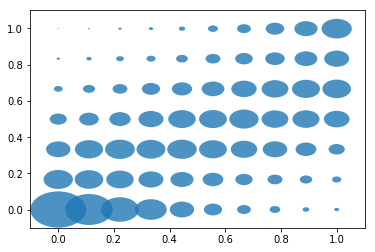

In [241]:
fig, ax = plt.subplots()

radii = .1*freq/max(freq)
patches = []
for x1, y1, r in zip(coords[:,0], coords[:,1], radii):
    circle = Circle((x1, y1), r)
    patches.append(circle)

p = PatchCollection(patches, alpha=0.8)
ax.add_collection(p)

plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

In [266]:
def plot_beta_2d_pdf(a1,b1,a2,b2):
    cuda_to_np = lambda x: x.detach().cpu().numpy()[0]
    a1 = cuda_to_np(a1)
    a2 = cuda_to_np(a2)
    b1 = cuda_to_np(b1)
    b2 = cuda_to_np(b2)
    
    mu_X = stats.beta.mean(a1,b1)
    mu_Y = stats.beta.mean(a2,b2)
    sig_X = stats.beta.var(a1,b1)**.5
    sig_Y = stats.beta.var(a2,b2)**.5
    fig, ax = plt.subplots()

    patches = []
    for x1, y1, rx, ry in zip(mu_X, mu_Y, sig_X, sig_Y):
        ell = Ellipse((x1, y1), rx, ry)
        patches.append(ell)

    p = PatchCollection(patches, alpha=0.8)
    ax.add_collection(p)

    plt.xlim(-.1,1.1)
    plt.ylim(-.1,1.1)

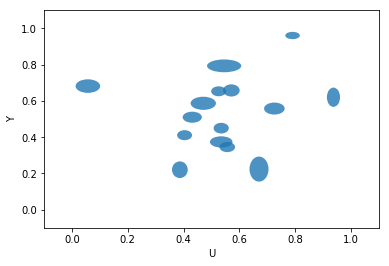

In [268]:
plot_beta_2d_pdf(model.a_u, model.b_u, model.a_y, model.b_y)
plt.xlabel('U');
plt.ylabel('Y');

#initialize p_z to
p_z = np.empty((N,K))
for i in range(N):
    p_z[i] = stats.beta.pdf(y_train[i], alphas, betas)
    #z_pred = np.argmax(stats.beta.pdf(y_train(i), alphas, betas))

### logit-normal dist
sigma = Symbol("sigma", positive=True)
mu = Symbol("mu", positive=True)
y = Symbol("y", positive=True)
pdf = sympy.exp(-(sympy.log(y/(1-y)) - mu)**2/(2*sigma**2)) * (1/(y*(1-y))) / (sigma*(2*pi)**.5)

dP_dy = pdf.diff(y).subs({sigma:1, mu:0})

scipy.optimize.broyden2(lambdify(y, dP_dy), [0.3])

In [296]:
M = IndexedBase('M')

In [297]:
i, j = symbols('i j', cls=Idx)

In [298]:
x = IndexedBase('x')

In [299]:
M[i, j]*x[j]

M[i, j]*x[j]

In [118]:
### beta distribution
a_y = Symbol("a", positive=True)
b_y = Symbol("b", positive=True)
y = Symbol("y", positive=True)
Y = sympy.stats.Beta('Y', a_y, b_y)
pdf = density(Y)(y)

In [119]:
pdf.diff(b_y)

y**(a - 1)*(-y + 1)**(b - 1)*(-polygamma(0, b) + polygamma(0, a + b))/beta(a, b) + y**(a - 1)*(-y + 1)**(b - 1)*log(-y + 1)/beta(a, b)

In [121]:
dP_db = pdf.diff(b_y).subs({a_y:1, y:.5})

In [ ]:
dP_da = pdf.diff(alpha).subs({beta:1, y:.5})

In [68]:
scipy.optimize.broyden1(lambdify(b_y, dP_db), [1])

array([1.44270175])

In [ ]:
Z = np.sum()

In [ ]:
p_ab_z

In [94]:
np.argmax(stats.beta.pdf(.5, alphas, betas))

9

In [ ]:
stats.invgamma.pdf()

In [ ]:
#random init
stats.invgamma.rvs(a=1, scale=1)

In [ ]:
objective = np.sum(np.log(np.sum))

In [ ]:
p_u_z = stats.beta.pdf(U, a, b)

# Neural network

In [5]:
def neg_ll(y_obs, p_z, alpha, beta):
    # p_z_pred are the predicted categorical distributions over z in 1...K
    # y_obs are the ground truth values of y
    p_y_obs = tf.zeros_like(y_obs)
    
    for z in range(1,K):
        p_y_z = tf.distributions.Beta(alpha[z], beta[z]).prob
        p_y_obs += p_y_z(y_obs) * p_z[z]

    return tf.reduce_mean(1-p_y_obs)


def mll_loss(a,b):
    def foo(y_obs, p_z):
        return neg_ll(y_obs, p_z, a,b)
    return foo

In [ ]:
a,b = 

In [1]:
model = ks.models.Sequential([
  ks.layers.Flatten(),
  ks.layers.Dense(512, activation=tf.nn.relu),
  ks.layers.Dropout(0.2),
  ks.layers.Dense(K, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss=mll_loss(a,b))

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11493376/11490434 [==============================] - 3s 0us/step
Epoch 1/5
60000/60000 [==============================] - 36s 593us/step - loss: 0.2194 - acc: 0.9347
Epoch 2/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.0943 - acc: 0.9714
Epoch 3/5
60000/60000 [==============================] - 9s 146us/step - loss: 0.0705 - acc: 0.9781
Epoch 4/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.0529 - acc: 0.9829
Epoch 5/5
10000/10000 [==============================] - 1s 56us/step


[0.07716192516259616, 0.9767]

In [ ]:
M = 64

In [ ]:
input_rgb = ks.layers.Input(shape=(M, x_train.shape[1:]))
x = ks.layers.Dense(1, activation='relu',name="Dense_1")(rgb_gray)

input_context = ks.layers.Input(shape=(M, 1))
x = ks.layers.concatenate([x, input_context], name="rbg_gray")
x = ks.layers.Dense(1, activation='softmax',name="softmax")(x)
naive_model = ks.models.Model(
        inputs=[input_rgb, input_gray, input_mix],
        outputs=[x])
naive_model.compile(optimizer='adam', loss='mse')

In [31]:
gamma(5)

24.36447344787283

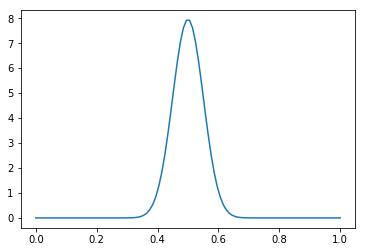

In [23]:
plt.plot(X,Y)

In [24]:
import tensorflow as tf
import sklearn.datasets as datasets

keras = tf.keras
layers = keras.layers

c = tf.ConfigProto()
c.gpu_options.allow_growth=True
sess = tf.Session(config=c)

In [22]:
tf.enable_eager_execution()

In [3]:
(data, target) = datasets.load_diabetes(True)

In [5]:
data.shape

(442, 10)

In [11]:
target.max()

25.0

In [15]:
p_male = data[:,1] > 0

In [16]:
p_male[:5]

array([ True, False,  True, False, False])

In [ ]:
data[:,1] = data[:,1] > 0

In [20]:
manifold = np.empty(128)

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


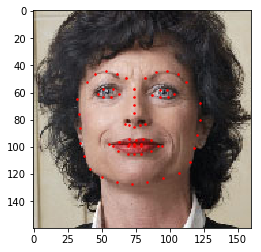

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

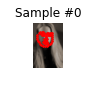

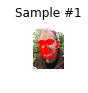

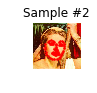

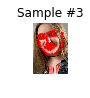

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    #print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


In [3]:
torch.device("cuda")

device(type='cuda')

In [28]:
N, D_in, H, D_out = 64, 1000, 100, 10

In [82]:
x = torch.randn(N, D_in).cuda()
y = torch.randn(N, D_out).cuda()

model = DynamicNet(D_in, H, D_out).cuda()
loss_fn = torch.nn.MSELoss(reduction='sum').cuda()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
for t in range(500):
    y_pred = model(x)
    
    loss = loss_fn(y_pred, y)
    print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

0 670.4612426757812
1 662.5904541015625
2 661.0430908203125
3 690.8719482421875
4 659.1820068359375
5 651.6021118164062
6 661.22802734375
7 662.5198974609375
8 660.832275390625
9 643.1038208007812
10 640.7529907226562
11 637.8424072265625
12 634.5338134765625
13 630.9481201171875
14 654.0599365234375
15 618.405517578125
16 621.03173828125
17 659.3185424804688
18 659.1572875976562
19 612.6932373046875
20 651.6414794921875
21 651.145751953125
22 650.52197265625
23 603.0089721679688
24 658.1094970703125
25 581.2460327148438
26 657.7459106445312
27 572.1170043945312
28 565.6786499023438
29 592.3092041015625
30 550.5504150390625
31 542.1099243164062
32 532.63916015625
33 656.635498046875
34 586.5438842773438
35 656.3221435546875
36 644.565185546875
37 582.7321166992188
38 643.6776733398438
39 481.3653259277344
40 642.5662841796875
41 641.8989868164062
42 641.1127319335938
43 574.924560546875
44 639.3850708007812
45 452.49346923828125
46 654.23486328125
47 654.0054931640625
48 636.0153808593

387 53.679134368896484
388 52.29256820678711
389 28.6053409576416
390 21.011470794677734
391 21.022382736206055
392 27.71293067932129
393 20.489789962768555
394 27.321321487426758
395 46.0142822265625
396 19.233837127685547
397 26.23712158203125
398 26.442768096923828
399 25.265541076660156
400 43.429866790771484
401 42.91234588623047
402 23.767471313476562
403 41.75527572631836
404 17.146156311035156
405 16.911483764648438
406 25.56455421447754
407 22.015493392944336
408 24.979944229125977
409 39.2034912109375
410 15.48620891571045
411 20.859378814697266
412 38.25577926635742
413 37.80916976928711
414 20.075544357299805
415 19.720869064331055
416 14.54012393951416
417 35.960453033447266
418 22.701196670532227
419 14.111820220947266
420 13.848587989807129
421 34.442665100097656
422 21.839988708496094
423 33.555885314941406
424 21.10539436340332
425 18.20099449157715
426 18.121782302856445
427 12.467421531677246
428 12.280736923217773
429 31.590530395507812
430 19.39765739440918
431 19.

In [85]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [81]:
class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred

In [52]:
class MyReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input